In [1]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
import json
import networkx as nx
import matplotlib.pyplot as plt
import math
import scipy.sparse
import pathlib, os

2023-11-29 15:56:19.837724: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 15:56:19.868757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 15:56:19.868816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 15:56:19.869800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 15:56:19.874480: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 15:56:19.875636: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
mp_face_mes = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
face_mesh = mp_face_mes.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: 

In [3]:
def preprocess_frame(frame):
    H, W, _ = frame.shape
    rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_mesh = face_mesh.process(rgb_image)
    mesh_points=np.array([np.multiply([p.x, p.y], [W, H]).astype(int) for p in results_mesh.multi_face_landmarks[0].landmark])
    nose_tip = mesh_points[4]
    forehead = mesh_points[151]
    scale_factor = np.linalg.norm(forehead - nose_tip)
    if np.isclose(scale_factor, 0):
        scale_factor = 1e-6
    return results_mesh, mesh_points, scale_factor

In [4]:
def gera_grafos(results_mesh, mesh_points, scale_factor):
    graph = nx.Graph()
    # sabing all the nodes from mesh_points into the graph
    for i in range(len(mesh_points)):
        graph.add_node(i, pos=mesh_points[i])
    return graph

In [5]:
def plot_graph(graph, mesh_points):
    plt.figure(figsize=(10,10))
    nx.draw_networkx(graph, pos=mesh_points, node_size=10, node_color='black', edge_color='black', with_labels=False)
    # flip the image upside down
    plt.gca().invert_yaxis()
    plt.show()

In [6]:
def get_matrix_adj(graph):
    matrix_adj = nx.adjacency_matrix(graph)
    sparce_matrix = scipy.sparse.csr_matrix(matrix_adj)
    return sparce_matrix    

In [7]:
def save_meshpoints(mesh_points, filename):
    path_name = pathlib.Path(filename).parent.absolute()
    emotion = path_name.name.split('_')[1]
    path_name = path_name.parent.absolute()
    path_name = path_name.joinpath(f'{emotion}_meshpoints')
    # separete the filename from the path
    filename = pathlib.Path(filename).absolute()
    # create te folder if it doesn't exist
    path_name.mkdir(parents=True, exist_ok=True)
    # save the npz file in the path_name
    file_out = path_name.joinpath(f'{filename.name}.json')
    with open(file_out, 'w') as outfile:
        json.dump(mesh_points.tolist(), outfile)

In [8]:
def pipeline(img, plot=False):
    name = img.split('.')[0]
    frame = cv2.imread(img)
    results_mesh, mesh_points, scale_factor = preprocess_frame(frame)
    graph = gera_grafos(results_mesh, mesh_points, scale_factor)
    # adjacency_matrix = get_matrix_adj(graph)
    # save_adjacency_matrix(adjacency_matrix, name)
    save_meshpoints(mesh_points, name)
    if plot:
        plot_graph(graph, mesh_points)

## Applying the pipeline to the training set

In [9]:
# print the actual path
print(pathlib.Path().absolute())

/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/GNN


In [10]:
current_path = pathlib.Path().absolute()
path = current_path.parent

angry_path = path / 'face_angry'
disgusted_path = path / 'face_disgusted'
happy_path = path / 'face_happy'
neutral_path = path / 'face_neutral'
sad_path = path / 'face_sad'
surprised_path = path / 'face_surprised'

path_list = [angry_path, disgusted_path, happy_path, neutral_path, sad_path, surprised_path]


/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/2711.jpg


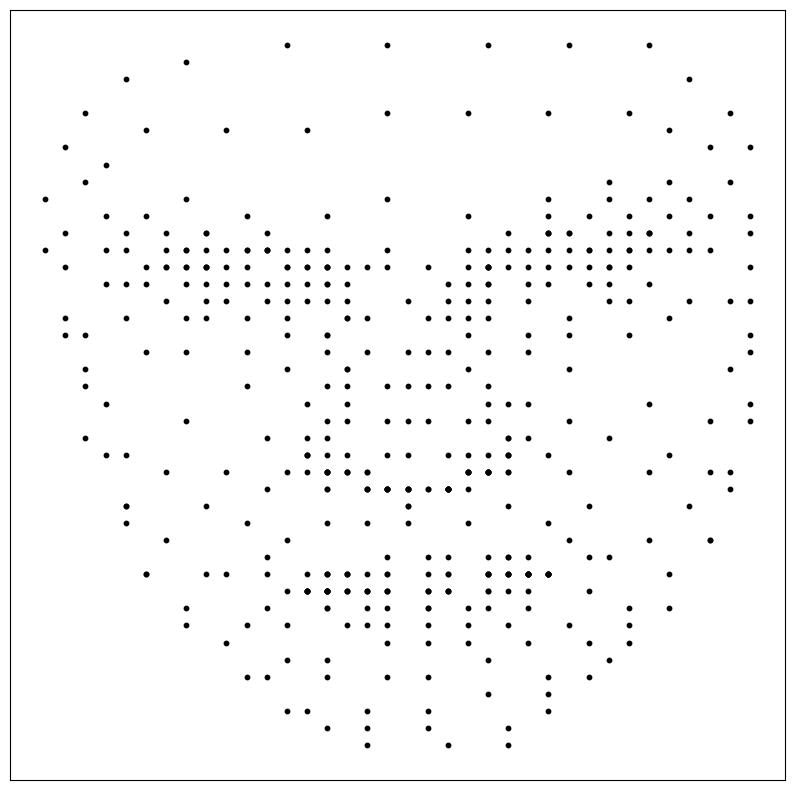

/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/6948.jpg


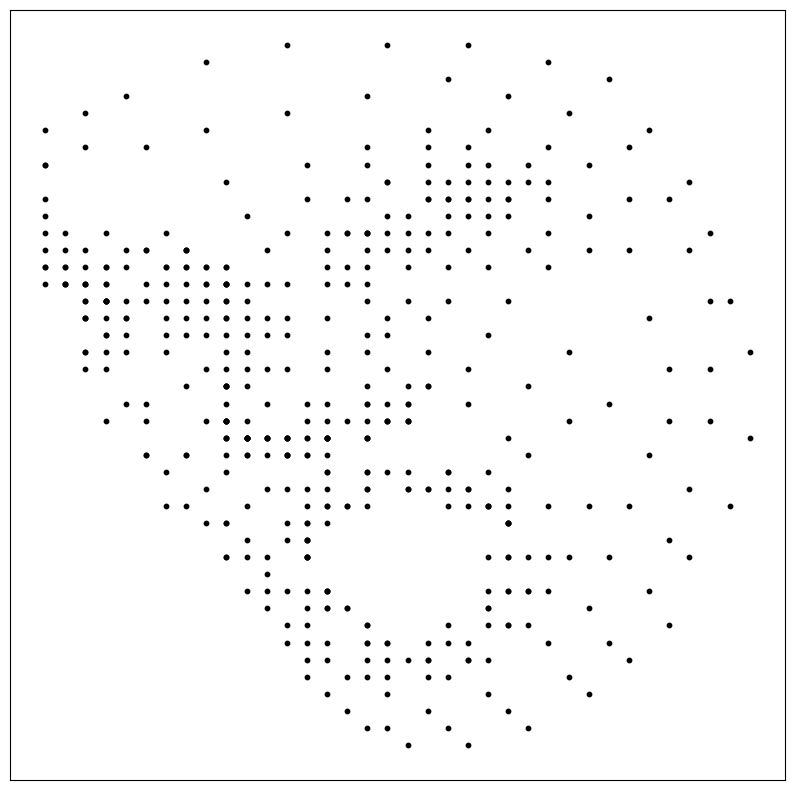

/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/25352.jpg


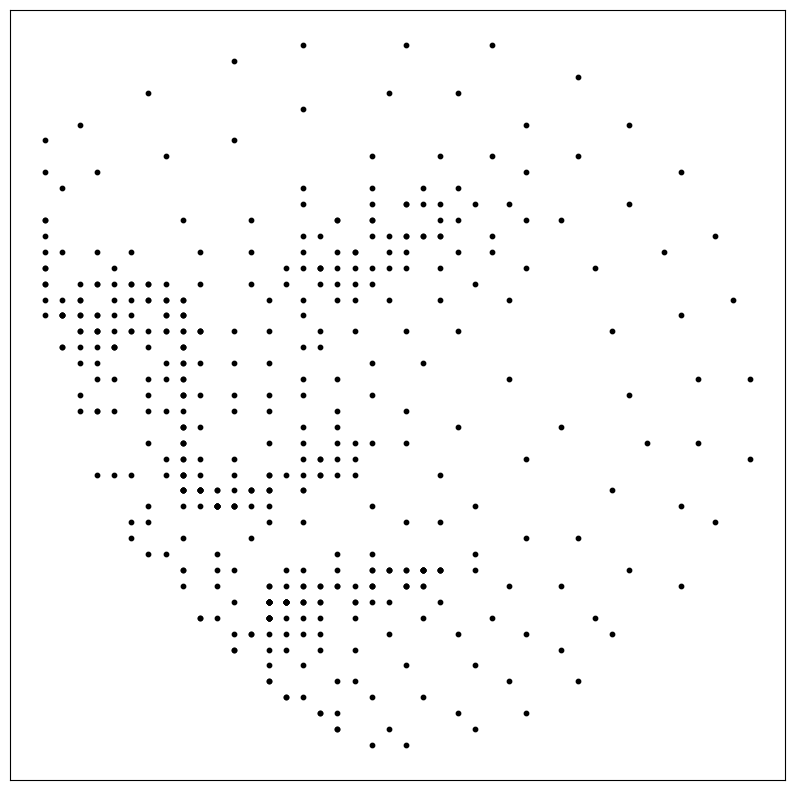

/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/29432.jpg


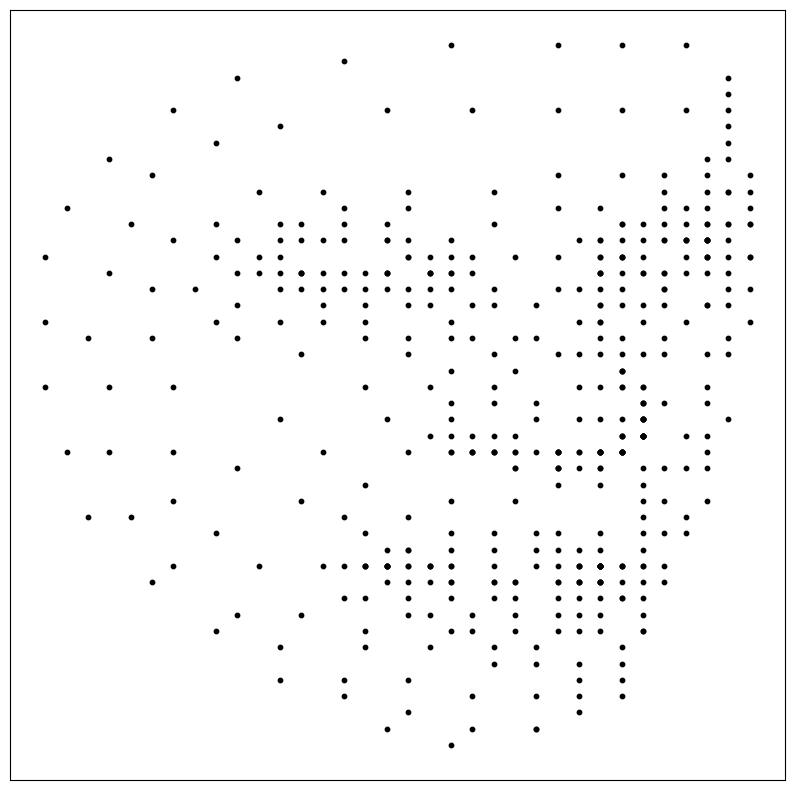

/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/frame_0452.jpg
'NoneType' object is not subscriptable
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/17926.jpg


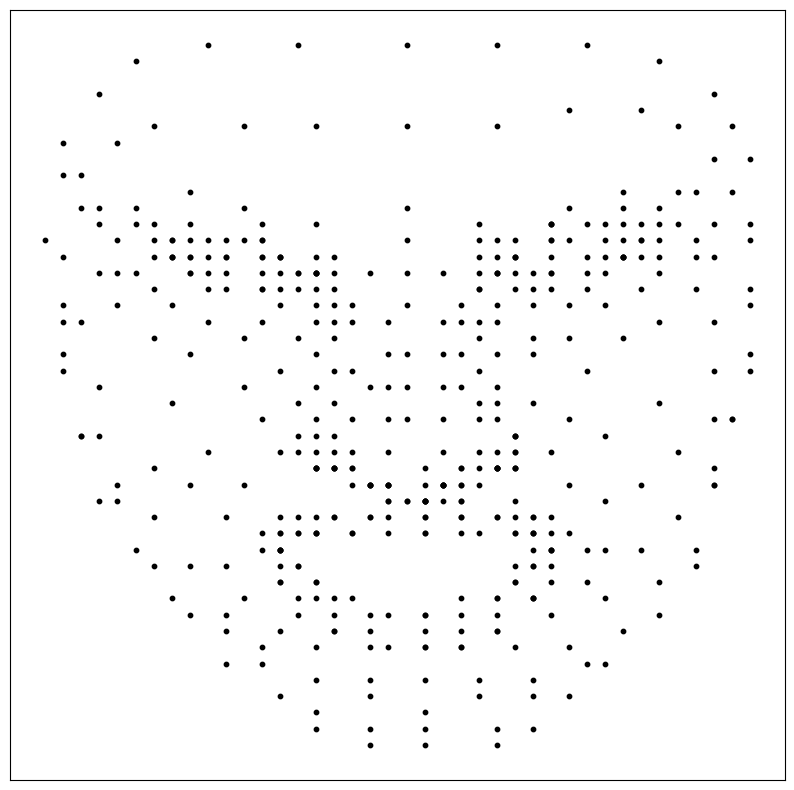

/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/30093
'NoneType' object has no attribute 'shape'
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry/frame_0287.jpg
'NoneType' object is not subscriptable
3


In [11]:
for emotion_path in path_list:
    count = 0
    p_c = 0
    print(emotion_path)
    emotion_files = os.listdir(emotion_path)
    for img in emotion_files:
        try:
            path_img = emotion_path / img
            print(path_img)
            pipeline(str(path_img), plot=True)
            if p_c == 10:
                break
            p_c += 1
        except Exception as e:
            print(e)
            count += 1
            if count == 3:
                break
    print(count)
    break

In [12]:
for emotion_path in path_list:
    count = 0
    img_count =1
    print(emotion_path)
    emotion_files = os.listdir(emotion_path)
    for img in emotion_files:
        try:
            path_img = emotion_path / img
            pipeline(str(path_img), plot=False)
            img_count += 1
        except Exception as e:
            #print(e)
            count += 1
            continue
    print('erros',count)

/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_angry
erros 1610
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_disgusted


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


erros 915
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_happy
erros 1794
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_neutral
erros 2528
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_sad
erros 4051
/home/arthur/Documentos/Insper/6_semestre/projetos_ml/projetoFinal/Facial-Emotion-Classification/face_surprised
erros 892


In [13]:
# print the amount of processed images
for emotion_path in path_list:
    print(len(os.listdir(emotion_path)))

5519
1899
9895
8254
9230
4711
